In [1]:
# !pip install tensorflow
#!pip uninstall keras-tuner
#!pip install keras_tuner
#!pip install shap
#!pip install tf-keras-vis tensorflow

In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import random
import matplotlib.pyplot as plt

import keras_tuner as kt
import tensorflow as tf
# print(tf.__version__)

In [24]:
# Load data
tickers = ['BND_enrich.csv', 'GLD_enrich.csv', 'GOVT_enrich.csv', 'IVOO_enrich.csv', 'JNK_enrich.csv', 'SPY_enrich.csv', 'VIOO_enrich.csv', 'VOO_enrich.csv']
ticker = tickers[5] 
print(f'Working for {ticker}')
data = pd.read_csv(ticker)
# Calculate Daily Volatility % (VOL)
data['VOL'] = (data['High'] - data['Low']) / data['Open'] * 100

# Drop the 'Open', 'High', 'Low' columns
data = data.drop(columns=['Open', 'High', 'Low'])

# Drop columns with any NA values
data = data.dropna(axis=1, how='any')
# Select features based on ticker
if ticker == 'BND_enrich.csv':
    features = ["3day MA", "Returns", "DGS10", "10day MA", "breakeven_rate", "VIXCLS", "month", 
                "DFII10", "day", "IRLTLT01USM156N", "EMVMACROBUS", "Std_dev", "EMVOVERALLEMV", 
                "CPALTT01USM661S", "O-C", "DGS2", "WALCL", "PAYEMS", "EMVMACROINTEREST", "RBUSBIS"]
elif ticker == 'GLD_enrich.csv':
    features = ["Returns", "3day MA", "day", "Std_dev", "10day MA", "O-C", "month", "Volume", 
                "EMVMACROINTEREST", "WALCL", "FEDFUNDS", "VIXCLS", "DGS3MO", "DGS10", "EMVMACROBUS", 
                "PAYEMS", "CPALTT01USM661S", "EMVOVERALLEMV", "VOL", "year", "H-L", "GDPC1", "DGS2", 
                "DFII10", "IRLTLT01USM156N", "RBUSBIS", "breakeven_rate", "Buy_Sell", 
                "Buy_Sell_on_Open", "Increase_Decrease"]
elif ticker == 'GOVT_enrich.csv':
    features = ["3day MA", "10day MA", "DGS10", "breakeven_rate", "DGS2", "Returns", "DFII10", 
                "EMVOVERALLEMV", "IRLTLT01USM156N", "month", "CPALTT01USM661S", "EMVMACROINTEREST", 
                "Std_dev", "PAYEMS", "VIXCLS"]
elif ticker == 'IVOO_enrich.csv':
    features = ["VIXCLS", "3day MA", "Returns", "month", "10day MA", "O-C", "EMVOVERALLEMV", "VOL", 
                "WALCL", "CPALTT01USM661S", "Std_dev", "EMVMACROINTEREST", "DFII10", "day", "GDPC1", 
                "year", "EMVMACROBUS", "IRLTLT01USM156N", "DGS10", "PAYEMS", "DGS3MO", "breakeven_rate", 
                "Volume", "Buy_Sell_on_Open", "H-L"]
elif ticker == 'JNK_enrich.csv':
    features = ["3day MA", "Returns", "VIXCLS", "10day MA", "DFII10", "month", "O-C", 
                "EMVOVERALLEMV", "breakeven_rate", "Std_dev", "VOL", "EMVMACROINTEREST", "GDPC1", 
                "RBUSBIS", "day", "EMVMACROBUS", "H-L", "IRLTLT01USM156N", "CPALTT01USM661S", 
                "PAYEMS", "DGS10", "year", "DGS2", "DGS3MO", "Volume"]
elif ticker == 'SPY_enrich.csv':
    features = ["Returns", "3day MA", "VIXCLS", "month", "O-C", "10day MA", "Volume", "VOL", 
                "CPALTT01USM661S", "day", "EMVOVERALLEMV", "WALCL", "EMVMACROINTEREST", 
                "breakeven_rate", "GDPC1"]
elif ticker == 'VIOO_enrich.csv':
    features = ["Returns", "VIXCLS", "3day MA", "O-C", "10day MA", "EMVOVERALLEMV", "month", "Std_dev", 
                "WALCL", "EMVMACROINTEREST", "day", "VOL", "CPALTT01USM661S", "GDPC1", "DGS3MO", 
                "DGS10", "year", "IRLTLT01USM156N", "DFII10", "breakeven_rate", "FEDFUNDS", "PAYEMS", 
                "Buy_Sell_on_Open", "DGS2", "EMVMACROBUS"]
elif ticker == 'VOO_enrich.csv':
    features = ["3day MA", "VIXCLS", "Returns", "month", "10day MA", "O-C", "VOL", "CPALTT01USM661S", 
                "EMVMACROINTEREST", "EMVOVERALLEMV", "WALCL", "GDPC1", "breakeven_rate", "day", "year", 
                "Std_dev", "RBUSBIS", "DFII10", "PAYEMS", "DGS10", "DGS3MO", "IRLTLT01USM156N", 
                "EMVMACROBUS", "H-L", "FEDFUNDS"]

# Select features and target
target = "Close"
data = data[features + [target]]
print(f'selected features:{features}')

Working for SPY_enrich.csv
selected features:['Returns', '3day MA', 'VIXCLS', 'month', 'O-C', '10day MA', 'Volume', 'VOL', 'CPALTT01USM661S', 'day', 'EMVOVERALLEMV', 'WALCL', 'EMVMACROINTEREST', 'breakeven_rate', 'GDPC1']


In [25]:
# Set seeds for reproducibility
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Split into features and target
X = scaled_data[:, :-1]
y = scaled_data[:, -1]

# Function to create sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

test_days = 90

In [26]:
# Hyperparameter tuning for GRU
def build_model(hp):
    model = Sequential()

    # Tune time steps
    time_steps = hp.Int('time_steps', min_value=5, max_value=30, step=5)
    X_seq, y_seq = create_sequences(X, y, time_steps)
    X_train, X_test = X_seq[:-test_days], X_seq[-test_days:]
    y_train, y_test = y_seq[:-test_days], y_seq[-test_days:]

    # Only one GRU layer
    model.add(LSTM(
        units=hp.Int('units', min_value=96, max_value=256, step=32),
        activation=hp.Choice('activation', values=['relu', 'tanh']),
        return_sequences=False,
        input_shape=(time_steps, X_train.shape[2]),
        recurrent_dropout=hp.Float('recurrent_dropout', min_value=0.0, max_value=0.5, step=0.1)
    ))
    
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])

    if hp_optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

    return model

# Initialize the tuner
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=25, executions_per_trial=2, directory='my_dir', project_name=f'lstm_hyperparameter_tuning_{ticker}')

# Create sequences based on initial time steps
initial_time_steps = 10
X_seq, y_seq = create_sequences(X, y, initial_time_steps)

# Split the dataset
test_days = 90
X_train, X_test = X_seq[:-test_days], X_seq[-test_days:]
y_train, y_test = y_seq[:-test_days], y_seq[-test_days:]

# Search for best hyperparameters
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal configuration is:
- Time steps: {best_hps.get('time_steps')}
- Units: {best_hps.get('units')}
- Dropout rate: {best_hps.get('dropout')}
- Recurrent dropout: {best_hps.get('recurrent_dropout')}
- Activation function: {best_hps.get('activation')}
- Learning rate: {best_hps.get('learning_rate')}
- Optimizer: {best_hps.get('optimizer')}
""")


Trial 25 Complete [00h 01m 19s]
val_loss: 0.0004267110925866291

Best val_loss So Far: 0.00011554458615137264
Total elapsed time: 02h 02m 04s

The hyperparameter search is complete. The optimal configuration is:
- Time steps: 5
- Units: 192
- Dropout rate: 0.1
- Recurrent dropout: 0.0
- Activation function: tanh
- Learning rate: 0.001
- Optimizer: adam



In [27]:
time_steps = 5
num_layers = 1
units = 192
activation = 'tanh'
dropout = 0.1
recurrent_dropout = 0.0
learning_rate= 0.001
optimizer = 'adam'

In [28]:
# Create sequences
X_seq, y_seq = create_sequences(X, y, time_steps)

# Split the dataset
test_days = 90
X_train, X_test = X_seq[:-test_days], X_seq[-test_days:]
y_train, y_test = y_seq[:-test_days], y_seq[-test_days:]

# Build the GRU model
model = Sequential()

# Add GRU layers based on the tuned parameters
for i in range(num_layers):
    if i == 0:
        model.add(LSTM(units=units, activation=activation, return_sequences=False,
                      input_shape=(time_steps, X_train.shape[2]),
                      recurrent_dropout=recurrent_dropout))
    else:
        model.add(LSTM(units=units, activation=activation, return_sequences=False,
                      recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout))

# Add the output layer
model.add(Dense(1))

# Compile the model
if optimizer == 'rmsprop':
    optimizer_instance = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
elif optimizer == 'adam':
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=learning_rate)
else:
    optimizer_instance = tf.keras.optimizers.SGD(learning_rate=learning_rate)

model.compile(optimizer=optimizer_instance, loss='mean_squared_error')

# Set seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# Evaluate the model
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predictions and the actual values
y_train_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train.shape[0], X_train.shape[2])), y_train.reshape(-1, 1))))[:, -1]
y_test_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], X_test.shape[2])), y_test.reshape(-1, 1))))[:, -1]

y_train_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_train_pred.shape[0], X_train.shape[2])), y_train_pred)))[:, -1]
y_test_pred_inv = scaler.inverse_transform(np.hstack((np.zeros((y_test_pred.shape[0], X_test.shape[2])), y_test_pred)))[:, -1]

# Calculate RMSE and MAPE for training data
rmse_train = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
mape_train = mean_absolute_percentage_error(y_train_inv, y_train_pred_inv)

# Calculate RMSE and MAPE for testing data
rmse_test = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
mape_test = mean_absolute_percentage_error(y_test_inv, y_test_pred_inv)

print(f"Training RMSE: {rmse_train}")
print(f"Training MAPE: {mape_train}")
print(f"Testing RMSE: {rmse_test}")
print(f"Testing MAPE: {mape_test}")

Epoch 1/100
108/108 [==============================] - 2s 12ms/step - loss: 0.0076 - val_loss: 0.0023
Epoch 2/100
108/108 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 6.9338e-04
Epoch 3/100
108/108 [==============================] - 1s 9ms/step - loss: 8.4486e-04 - val_loss: 4.0422e-04
Epoch 4/100
108/108 [==============================] - 1s 9ms/step - loss: 7.0318e-04 - val_loss: 3.0379e-04
Epoch 5/100
108/108 [==============================] - 1s 9ms/step - loss: 5.5282e-04 - val_loss: 1.5364e-04
Epoch 6/100
108/108 [==============================] - 1s 9ms/step - loss: 4.7642e-04 - val_loss: 5.8481e-04
Epoch 7/100
108/108 [==============================] - 1s 10ms/step - loss: 4.7218e-04 - val_loss: 1.6096e-04
Epoch 8/100
108/108 [==============================] - 1s 9ms/step - loss: 4.2701e-04 - val_loss: 3.1751e-04
Epoch 9/100
108/108 [==============================] - 1s 9ms/step - loss: 4.3208e-04 - val_loss: 5.4226e-04
Epoch 10/100
108/108 [=======

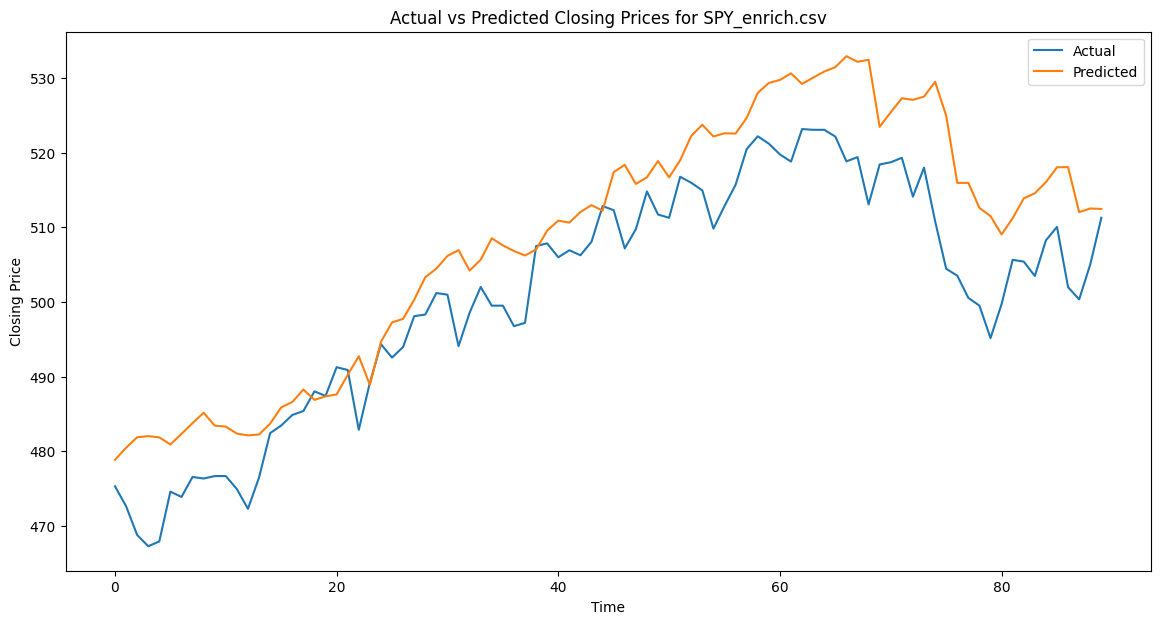

In [29]:
# Plot the actual vs. predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_test_pred_inv, label='Predicted')
plt.title(f'Actual vs Predicted Closing Prices for {ticker}')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [30]:
model.save(f'best_model_lstm_{ticker}.keras')
#from tensorflow.keras.models import load_model
#model = load_model(f'best_model_{ticker}.keras')
#print(f'Model loaded for {ticker}')

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 192)               159744    
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 193       
                                                                 
Total params: 159937 (624.75 KB)
Trainable params: 159937 (624.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
import shap
# Create an explainer
explainer = shap.GradientExplainer(model, X_train)
# Compute SHAP values for the training and test sets
shap_values_train = explainer.shap_values(X_train)
shap_values_test = explainer.shap_values(X_test)

c:\Users\KUNAL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


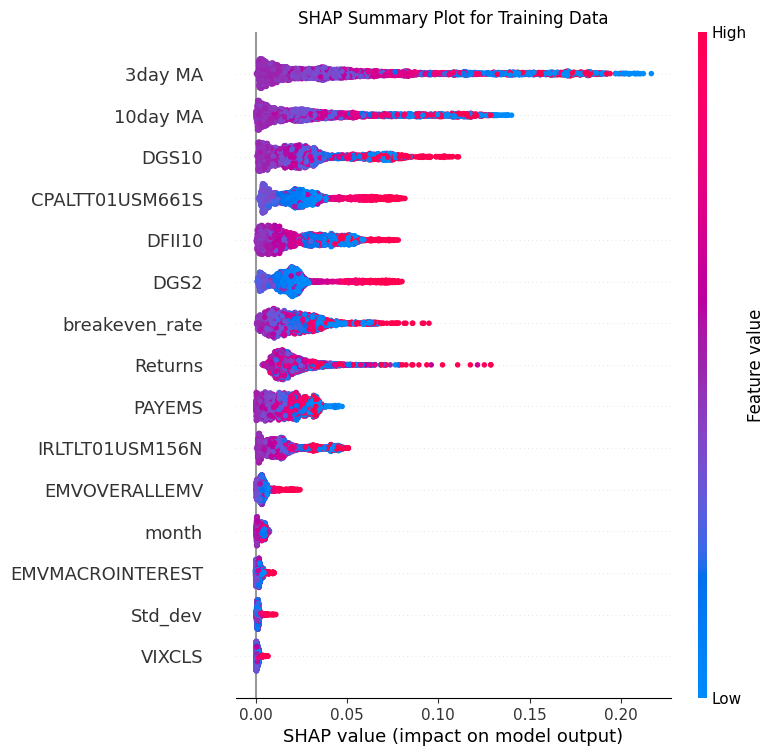

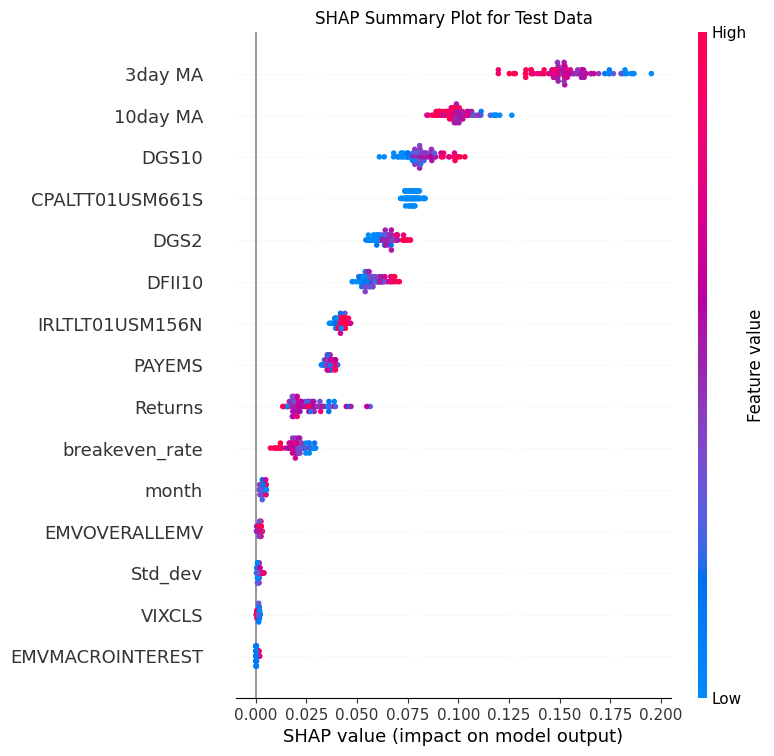

In [13]:
# Set seeds for reproducibility
seed = 2024
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Ensure that the SHAP library is initialized
shap.initjs()

# Aggregate SHAP values over time steps by summing absolute values
shap_values_train_aggregated = np.sum(np.abs(shap_values_train), axis=1).reshape(X_train.shape[0], -1)
shap_values_test_aggregated = np.sum(np.abs(shap_values_test), axis=1).reshape(X_test.shape[0], -1)

# Aggregate the corresponding features by taking the mean across time steps
X_train_aggregated = np.mean(X_train, axis=1)
X_test_aggregated = np.mean(X_test, axis=1)

# Plot the summary plot for feature importance (Train Data)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_train_aggregated, features=X_train_aggregated, feature_names=features, show=False)
plt.title('SHAP Summary Plot for Training Data')
plt.show()

# Plot the summary plot for feature importance (Test Data)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_test_aggregated, features=X_test_aggregated, feature_names=features, show=False)
plt.title('SHAP Summary Plot for Test Data')
plt.show()

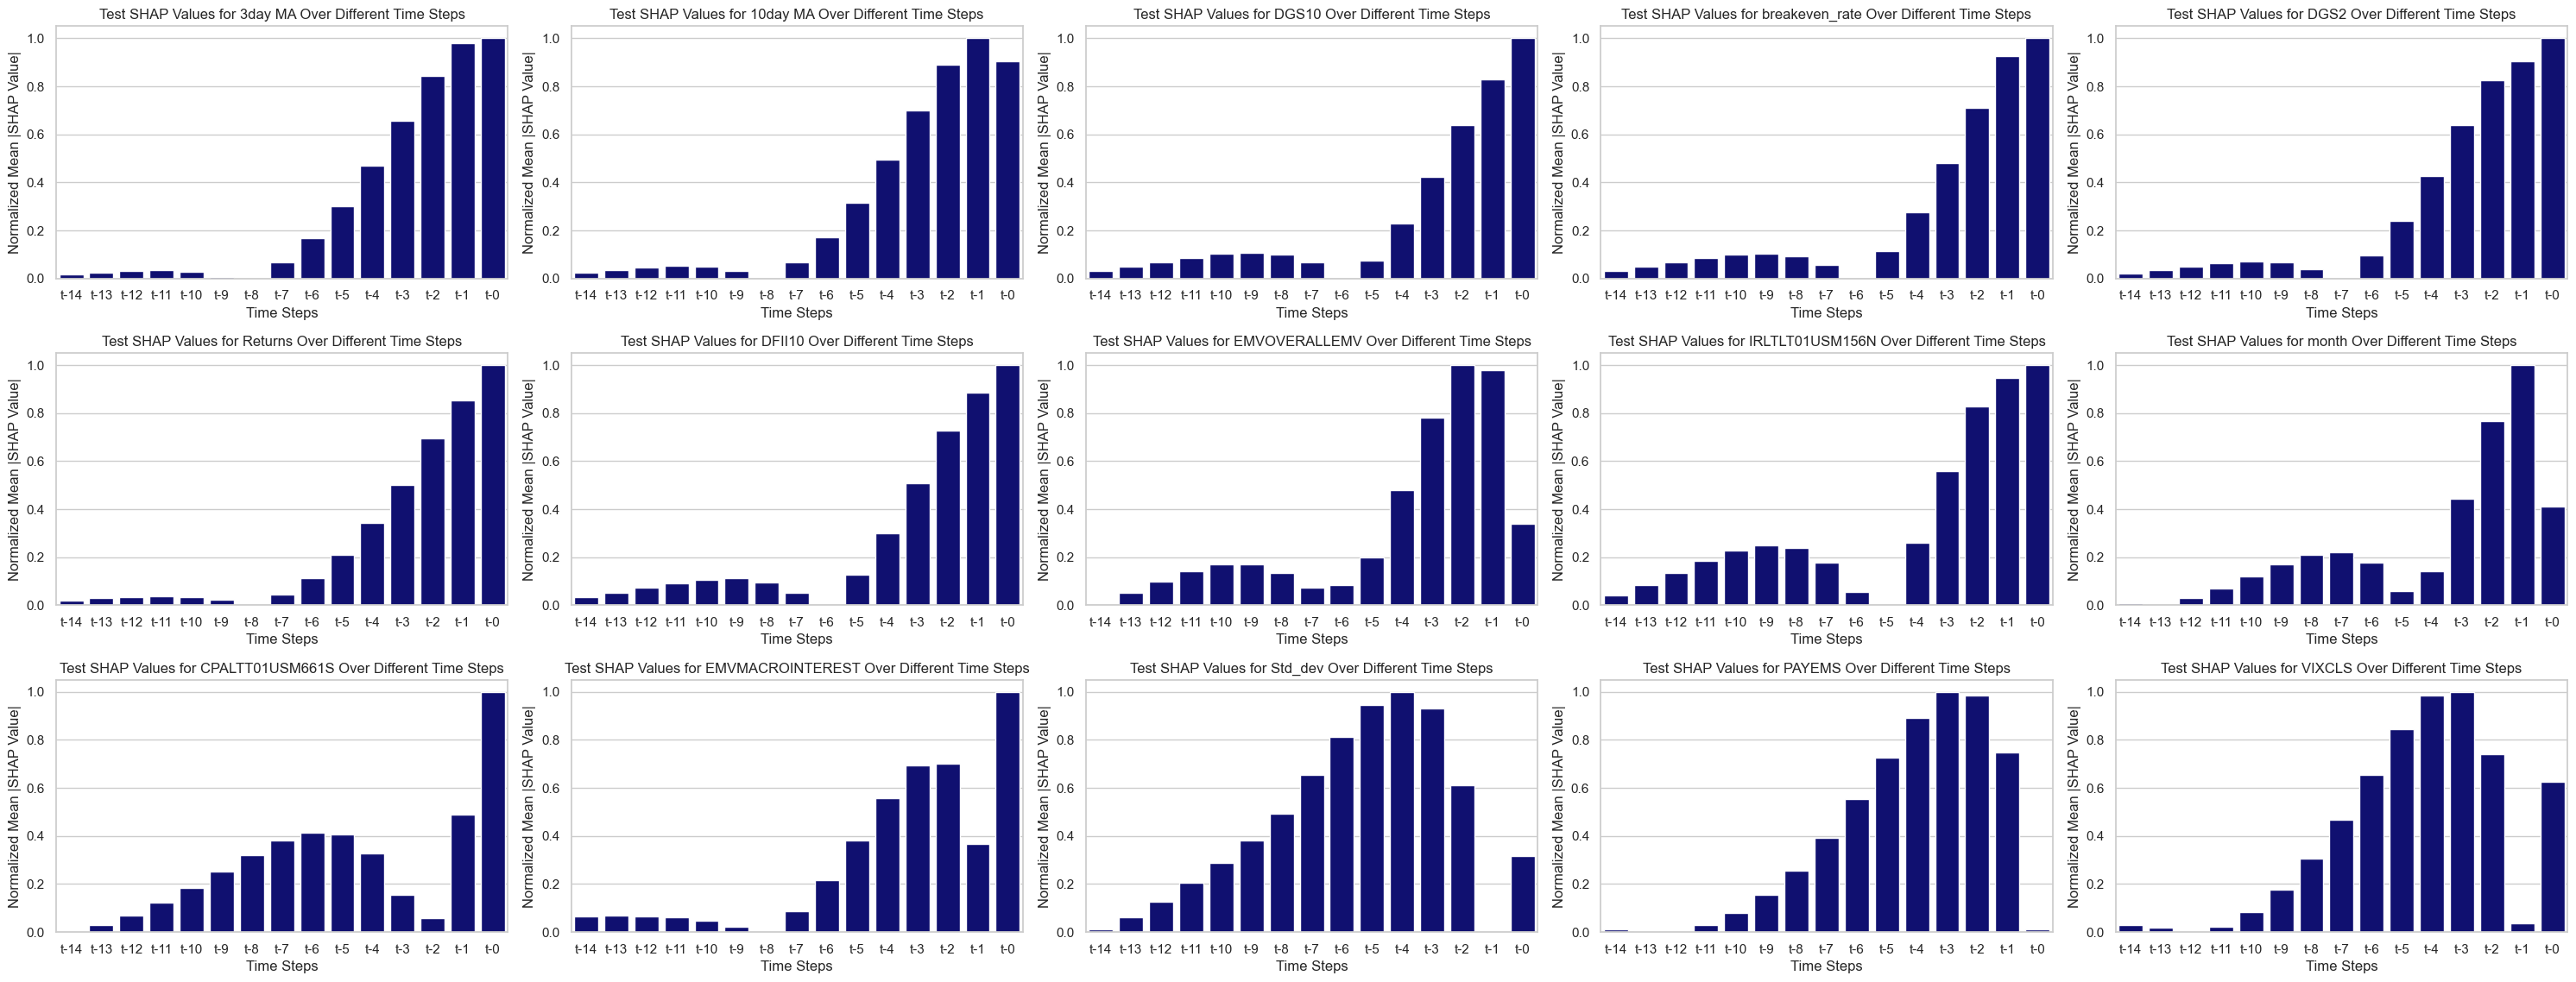

In [14]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Extract and reshape SHAP values for each feature and time step
time_steps = X_train.shape[1]

def plot_shap_values_over_time(shap_values, X, feature_names, title_prefix):
    num_features = len(feature_names)
    time_steps = X.shape[1]
    
    fig, axes = plt.subplots(nrows=num_features // 2 + num_features % 2, ncols=5, figsize=(30, num_features * 2))
    axes = axes.flatten()
    
    for i, feature in enumerate(feature_names):
        shap_values_feature = np.array([shap[:, i] for shap in shap_values]).reshape(-1, time_steps)
        mean_shap_values = np.mean(np.abs(shap_values_feature), axis=0)
        
        # Normalize the mean SHAP values to the range [0, 1]
        mean_shap_values = (mean_shap_values - mean_shap_values.min()) / (mean_shap_values.max() - mean_shap_values.min())
        
        time_steps_labels = [f't-{j}' for j in range(time_steps-1, -1, -1)]
        
        # Use a single color for the bars
        sns.barplot(ax=axes[i], x=time_steps_labels, y=mean_shap_values, dodge=False, color="navy")
        axes[i].set_title(f'{title_prefix} SHAP Values for {feature} Over Different Time Steps')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel('Normalized Mean |SHAP Value|')

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

# Plot SHAP values for each feature in the test data
plot_shap_values_over_time(shap_values_test, X_test, features, 'Test')


In [ ]:
import shap
import numpy as np

# Assuming the last observation from X_test is what you want to explain
# Sum the SHAP values across all time steps for each feature
shap_values_last_obs = shap_values_test[0].sum(axis=0).flatten()  # Summing across the time steps and flattening

# Ensure the SHAP values are a 1D array (for a single output model)
if len(shap_values_last_obs.shape) > 1:
    shap_values_last_obs = shap_values_last_obs[:, 0]  # Take the first output if there's more than one

# Extract the feature values for the last observation
data_last_time_step = X_test[-1, -1, :]  # Most recent time step's feature values

# Inverse transform the feature values to get them back to their original scale
full_feature_row = np.zeros((1, len(features) + 1))
full_feature_row[0, :-1] = data_last_time_step
full_feature_row_unscaled = scaler.inverse_transform(full_feature_row)
data_last_time_step_unscaled = full_feature_row_unscaled[0, :-1]  # Remove the appended zero for the target

# Compute the expected value manually on scaled data
expected_value_scaled = model.predict(X_train).mean()

# Unscale the expected value
expected_value_unscaled = scaler.inverse_transform([[0] * len(features) + [expected_value_scaled]])[0, -1]

# Adjust SHAP values to match the unscaled values
shap_values_last_obs_unscaled = shap_values_last_obs * scaler.data_range_[-1]  # Rescale SHAP values based on the target variable's range

# Predict the unscaled value for the last observation
last_observation_prediction = model.predict(data_last_time_step_unscaled)
last_observation_prediction_unscaled = scaler.inverse_transform([[0] * len(features) + [last_observation_prediction]])[0, -1]

# Create the SHAP waterfall plot with unscaled data
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_obs_unscaled,  # Unscaled SHAP values for the last observation
        base_values=expected_value_unscaled,  # Unscaled base value
        data=data_last_time_step_unscaled,  # Unscaled feature values for the last time step
        feature_names=features  # List of feature names
    )
)


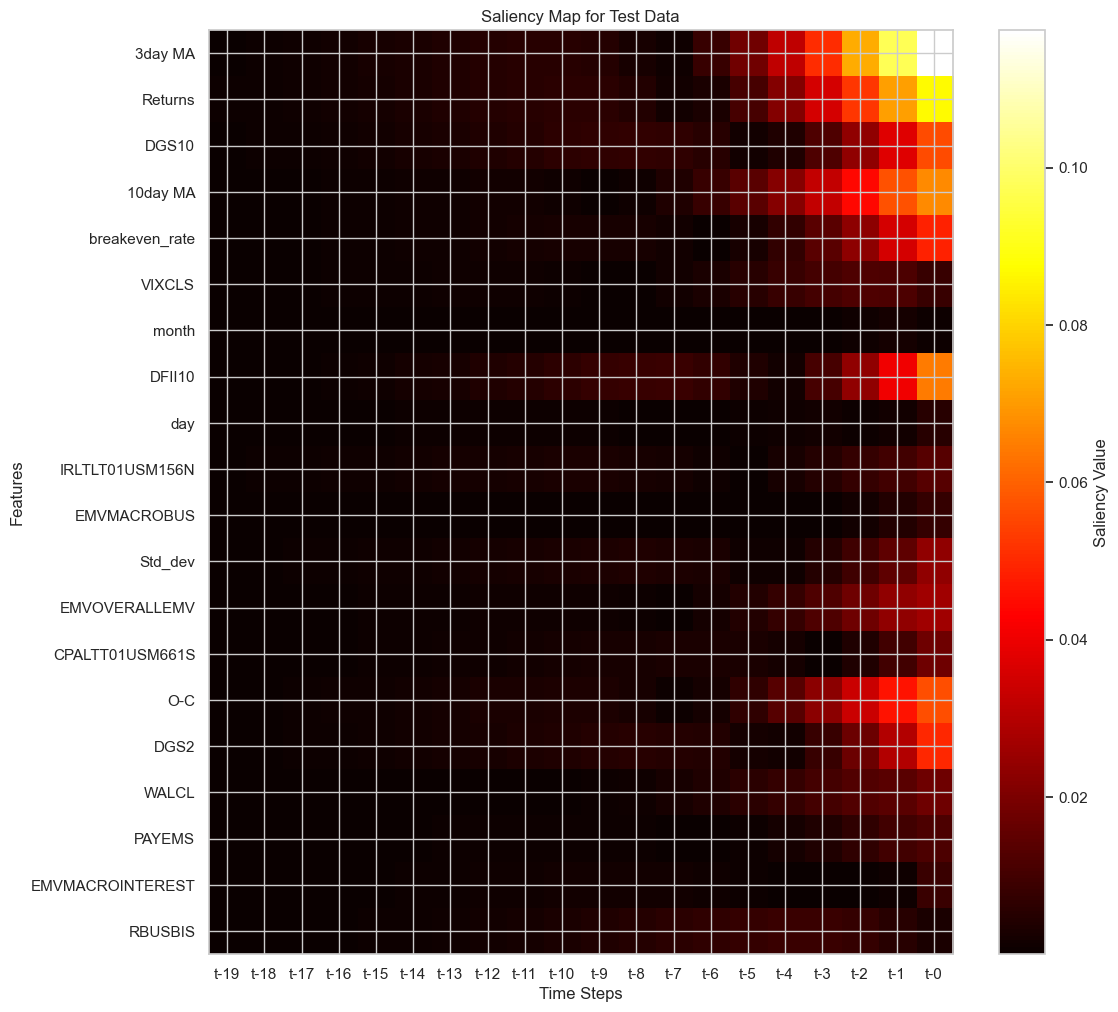

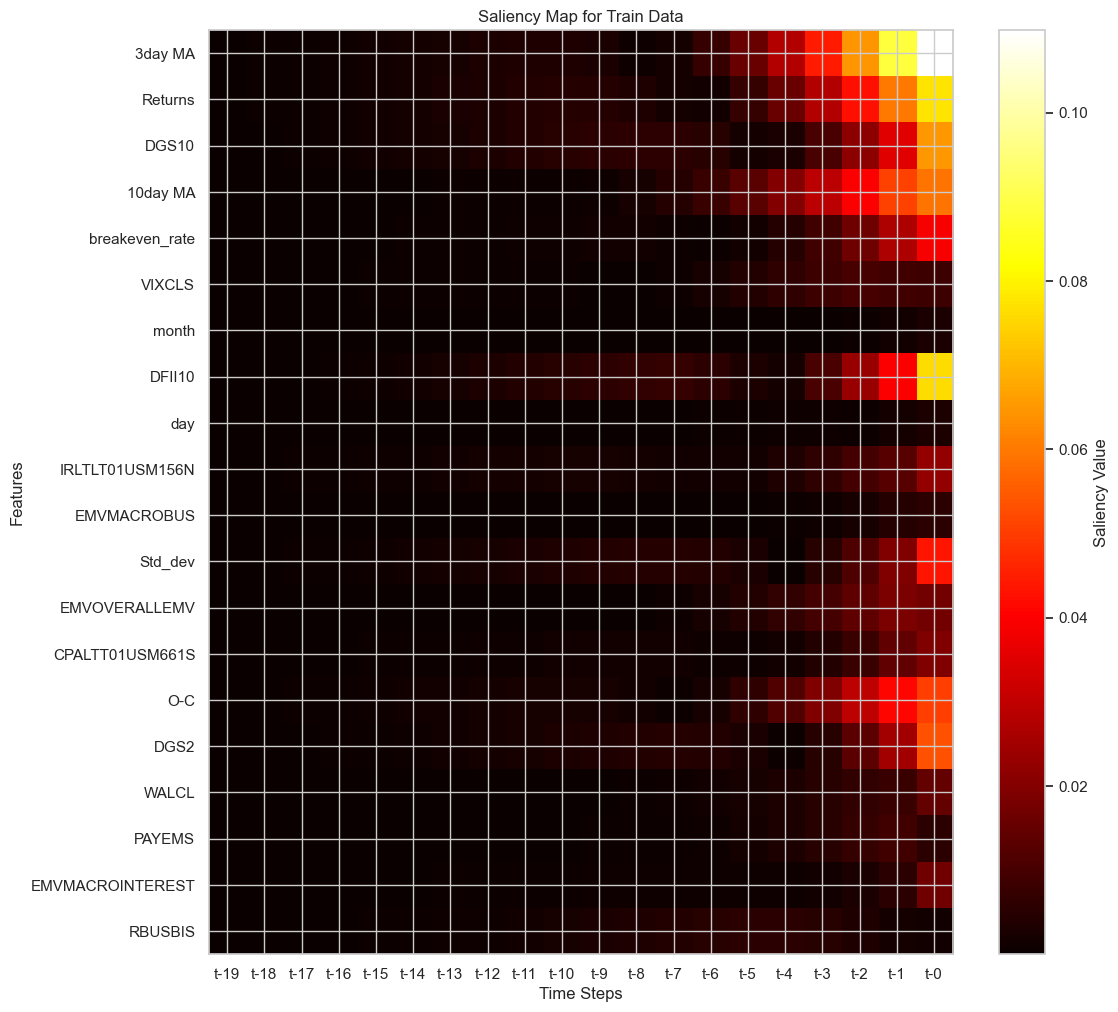

In [ ]:
# Convert numpy arrays to tensors
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)

# Function to compute saliency map
def compute_saliency_map(model, X):
    with tf.GradientTape() as tape:
        tape.watch(X)
        predictions = model(X)
    gradients = tape.gradient(predictions, X)
    return tf.abs(gradients).numpy()

# Compute saliency maps for test data
saliency_maps_test = compute_saliency_map(model, X_test_tensor)
saliency_maps_train = compute_saliency_map(model, X_train_tensor)

def plot_saliency_map(saliency_map, feature_names, title="Saliency Map"):
    mean_saliency_map = np.mean(saliency_map, axis=0)  # Average over samples
    plt.figure(figsize=(12, 12))
    plt.imshow(mean_saliency_map.T, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar(label='Saliency Value')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Features')
    plt.xticks(ticks=np.arange(saliency_map.shape[1]), labels=[f't-{i}' for i in range(saliency_map.shape[1]-1, -1, -1)])
    plt.yticks(ticks=np.arange(len(feature_names)), labels=feature_names)
    plt.show()

# Feature names
# features = ["RSI_Close", "Open", "macd", "rpi", "lag1", "Nifty50", "AvgTrueRange", "DEMA_Close_F", "eps", "COD"]

# Plot saliency map for the test data
plot_saliency_map(saliency_maps_test, features, title="Saliency Map for Test Data")
plot_saliency_map(saliency_maps_train, features, title="Saliency Map for Train Data")

3/3 [==============================] - 0s 9ms/step


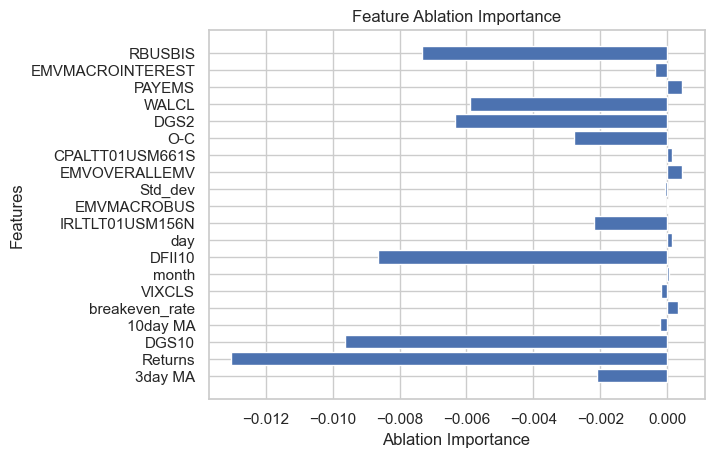

In [ ]:
def feature_ablation(model, X, y, feature_names):
    base_score = mean_squared_error(y, model.predict(X))
    scores = []

    for i in range(X.shape[-1]):
        X_ablated = X.copy()
        X_ablated[:, :, i] = 0  # Ablate the feature
        score = mean_squared_error(y, model.predict(X_ablated))
        scores.append(base_score - score)

    plt.barh(feature_names, scores)
    plt.xlabel('Ablation Importance')
    plt.ylabel('Features')
    plt.title('Feature Ablation Importance')
    plt.show()

# Compute feature ablation scores with actual feature names
feature_ablation(model, X_test, y_test, features)



In [16]:
import lime
from lime.lime_tabular import RecurrentTabularExplainer
import numpy as np

# Assume `X_test` is your test dataset and `model` is your trained Keras model
# Extract the last test observation
last_observation = X_test[-1].reshape(1, time_steps, X_train.shape[2])

# Initialize the RecurrentTabularExplainer for sequential data
explainer = RecurrentTabularExplainer(
    training_data=X_train,  # Training data with original shape
    training_labels=y_train,  # Training labels
    feature_names=features,  # Feature names for each time step
    mode='regression'
)

# Explain the prediction for the last test observation
exp = explainer.explain_instance(
    data_row=last_observation,  # The observation to explain
    classifier_fn=model.predict,  # The model's prediction function
    num_features=10  # Number of features to explain
)

# Display the explanation
exp.show_in_notebook(show_all=False)


157/157 [==============================] - 1s 9ms/step


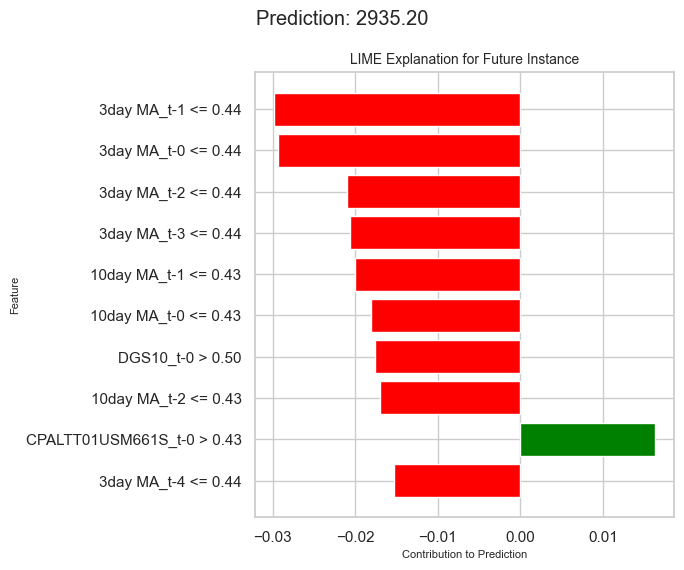

In [17]:
# Plot the explanation
fig = exp.as_pyplot_figure()
plt.title('LIME Explanation for Future Instance', fontsize=10)
plt.suptitle('Prediction: 2935.20')
plt.xlabel('Contribution to Prediction', fontsize=8)
plt.ylabel('Feature', fontsize=8)
plt.gcf().set_size_inches(7, 5.8)
plt.tight_layout()
plt.show()